##Geothermal Anomaly Detection Using Remote Sensing and Unsupervised Machine Learning (Isolation Forest)


Isolation Forest Anomaly Detection
To complement KMeans clustering, we applied Isolation Forest, a powerful unsupervised algorithm specifically designed for anomaly detection in high-dimensional data.
💡 Why Isolation Forest?
    It isolates anomalies instead of profiling normal data.
    Anomalies are easier to isolate and require fewer random partitions.
    It is efficient for large datasets and non-linear boundaries.

📥 Input Features

We used three standardized surface parameters:

    NDVI – Vegetation index (greener = healthier)
    LST – Land Surface Temperature (°C)
    VV – InSAR backscatter (vertical deformation indicator)

⚙️ Procedure

    1. Data Preparation
    2. Standardize the input features using StandardScaler.
    3. Train an IsolationForest model with 1% contamination (expected anomaly rate).
    4. Generate:
        is_anomaly: Boolean flag for anomalous data points.
        anomaly_score: Inverted decision function (higher = more anomalous).

🗺️ Output Visualization

    A 2D geographic map shows the spatial distribution of anomaly scores.
    A heatmap layer overlays the full survey area.
    Points detected as anomalies are plotted in blue on the map.

# 1. Data Preparation

In [25]:
!pip install -q gdown

Downloading...
From: https://drive.google.com/uc?id=16nMQLdlwnRrm1dskDif5GGLZqzMWAMRj
To: /content/Solok_Remote_Sensing.csv
100%|██████████| 6.63M/6.63M [00:00<00:00, 28.0MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42495 entries, 0 to 42494
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  42495 non-null  object 
 1   LST           42495 non-null  float64
 2   NDVI          42495 non-null  float64
 3   VV            42495 non-null  float64
 4   .geo          42495 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1.6+ MB
----------------- Checking Structure -------------------
Remaining rows: 29767
Columns: ['system:index', 'LST', 'NDVI', 'VV', 'lon', 'lat']
Preview:
     system:index        LST      NDVI         VV         lon       lat
37         0_43_0 -15.727842  0.587288  -8.272573  100.589528 -0.579279
1060     0_1373_0 -15.621029  0.297405  -9.982251  100.588989 -0.581704
1540        1_1_0 -10.210303  0.180247  -6.767043  100.999698 -1.259213
1541        1_5_0  -7.451961  0.408135 -11.513838  101.013712 -1.105332
1542        1_7_0   2.533784  

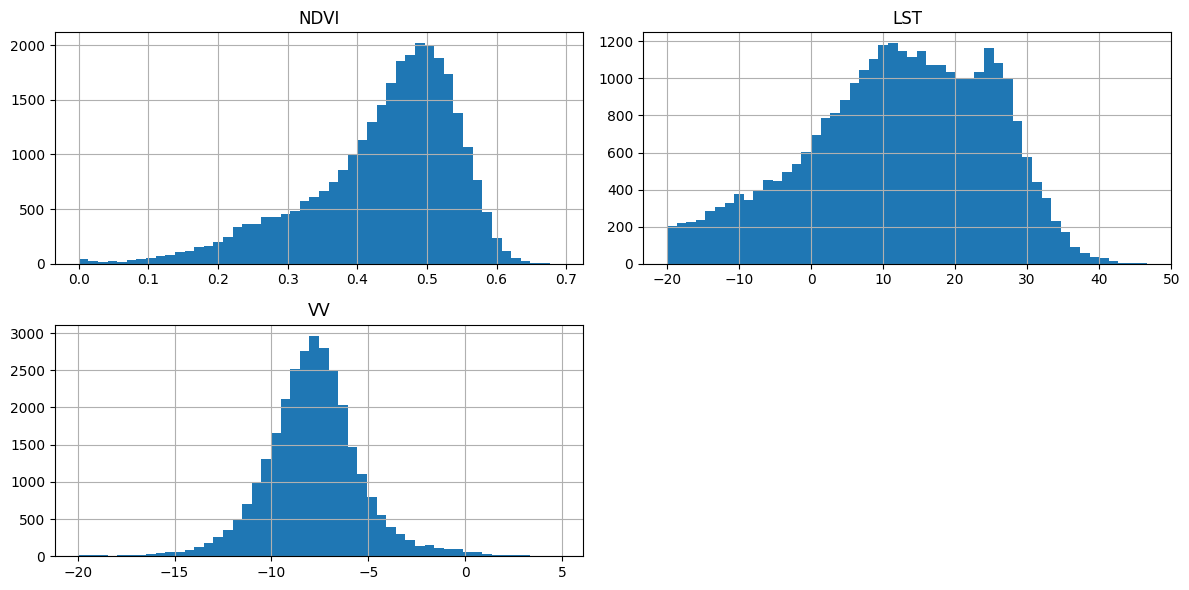

---------------- Checking for Remaining Outliers --------------------
Min/Max LST after cleaning: -19.999512579999973 / 46.677512570000005
Remaining data points: 29767


In [31]:

# File ID extracting from link
# Link: https://drive.google.com/file/d/16nMQLdlwnRrm1dskDif5GGLZqzMWAMRj/view?usp=sharing
file_id = "16nMQLdlwnRrm1dskDif5GGLZqzMWAMRj"
output_path = "Solok_Remote_Sensing.csv"

# Download file
import gdown
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

# Load with pandas
import pandas as pd
df = pd.read_csv(output_path)

# Display preview
df.info()
df.head()

import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast

# ✅ Parse geometry and extract lat/lon if '.geo' column exists
if '.geo' in df.columns:
    df[['lon', 'lat']] = df['.geo'].apply(lambda g: json.loads(g)['coordinates']).apply(pd.Series)
    df = df.drop(columns=['.geo'])

# ✅ Drop rows with any missing values
df = df.dropna()

# ✅ Filter out implausible physical values
df = df[(df['LST'] >= -20) & (df['LST'] <= 60)]       # LST in °C
df = df[(df['NDVI'] >= 0) & (df['NDVI'] <= 1)]        # NDVI dimensionless (0–1)
df = df[(df['VV'] >= -20) & (df['VV'] <= 5)]          # VV in dB

# ✅ Check structure
print ("----------------- Checking Structure -------------------")
print("Remaining rows:", len(df))
print("Columns:", df.columns.tolist())
print("Preview:")
print(df.head())

# ✅ Feature scaling for modeling
features = df[['NDVI', 'LST', 'VV']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# ✅ Check Summary Statistics
print ("---------------- Checking Summary Statistics --------------------")
print(df.describe())

# ✅ Visualize Distributions (Histograms)
print ("---------------- Distribution Visualization --------------------")
df[['NDVI', 'LST', 'VV']].hist(bins=50, figsize=(12, 6))
plt.tight_layout()
plt.show()

# ✅Checking for the remaining outliers
print ("---------------- Checking for Remaining Outliers --------------------")
print("Min/Max LST after cleaning:", df['LST'].min(), "/", df['LST'].max())
print("Remaining data points:", len(df))

# ✅ Save cleaned unscaled data
df.to_csv("Solok_RemoteSensing_Cleaned.csv", index=False)

# ✅ Optional: download directly to your computer
#from google.colab import files
#files.download("Solok_RemoteSensing_Cleaned.csv")

# 2. Standardize the input features using StandardScaler & Train the model using Isolation Forest

In [36]:
!pip install -q pandas matplotlib scikit-learn

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Step 2: Load cleaned dataset
df = pd.read_csv("Solok_RemoteSensing_Cleaned.csv")  # Adjust path if needed

# Step 3: Feature selection and scaling
features = ['NDVI', 'LST', 'VV']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Step 4: Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(scaled_features)  # ✅ This line was missing

# Step 5: Predict anomaly scores and labels
df['anomaly_score'] = iso_forest.decision_function(scaled_features)
df['is_anomaly'] = pd.Series(iso_forest.predict(scaled_features), index=df.index).map({1: 0, -1: 1})

# 3. Visualization
a. 3D Anomaly Score Visualization

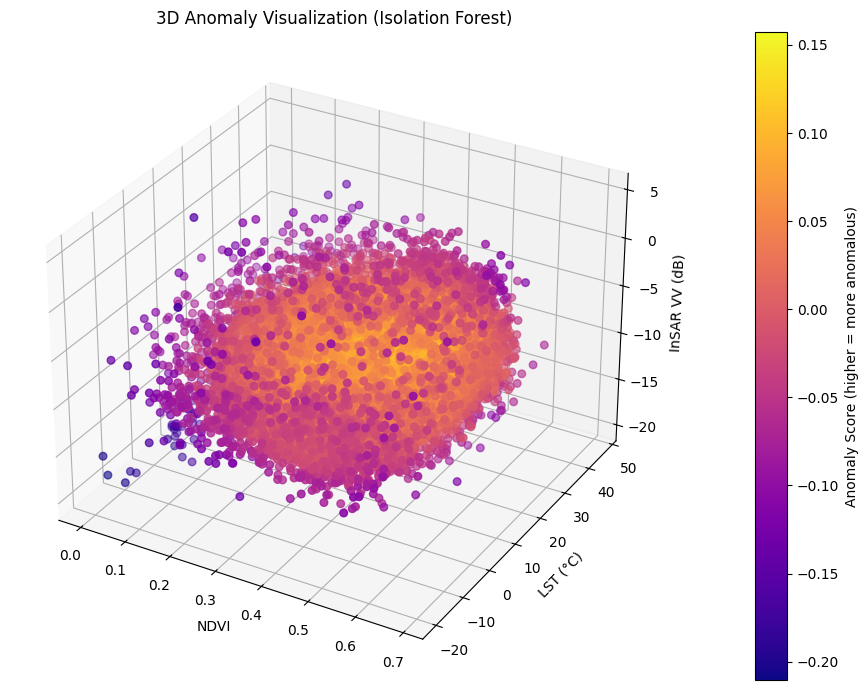

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create figure and 3D axes
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using NDVI, LST, VV as axes, colored by anomaly score
scatter = ax.scatter(
    df['NDVI'], df['LST'], df['VV'],
    c=df['anomaly_score'], cmap='plasma', s=30
)

# Set labels
ax.set_xlabel('NDVI')
ax.set_ylabel('LST (°C)')
ax.set_zlabel('InSAR VV (dB)')
ax.set_title('3D Anomaly Visualization (Isolation Forest)')

# Add color bar to indicate anomaly intensity
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Anomaly Score (higher = more anomalous)')

# Show plot
plt.tight_layout()
plt.show()


b. 3D Scatter Plot (Color by Binary Anomaly Classification)

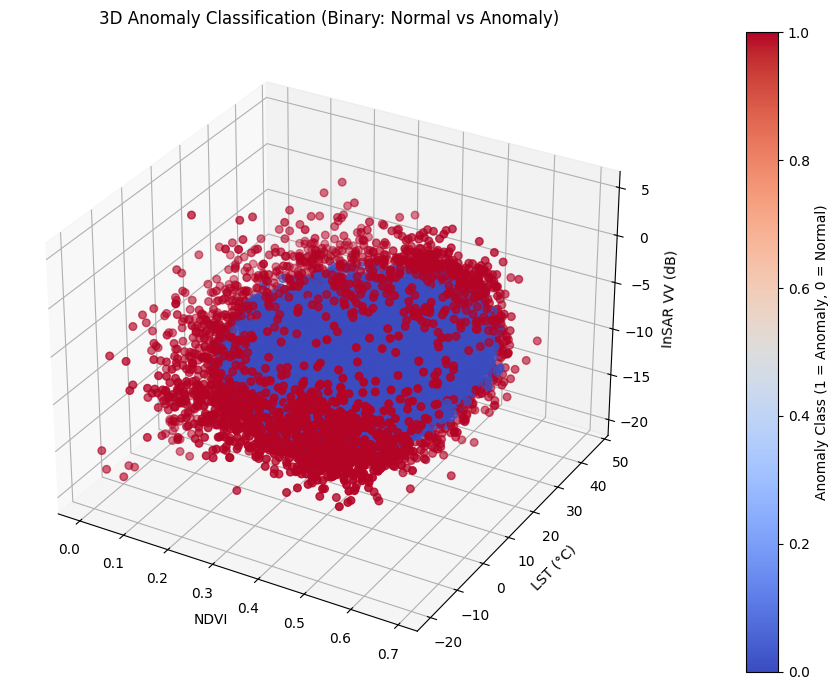

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create 3D plot colored by is_anomaly
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['NDVI'], df['LST'], df['VV'],
    c=df['is_anomaly'], cmap='coolwarm', s=30
)

ax.set_xlabel('NDVI')
ax.set_ylabel('LST (°C)')
ax.set_zlabel('InSAR VV (dB)')
ax.set_title('3D Anomaly Classification (Binary: Normal vs Anomaly)')

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Anomaly Class (1 = Anomaly, 0 = Normal)')

plt.tight_layout()
plt.show()


#4. Overlay to geographic map

In [47]:
!pip install folium


In [51]:
# Install Folium if not installed
!pip install -q folium

# Import Folium and tools
import folium
from folium.plugins import MarkerCluster

# Step 1: Center map around Solok
map_center = [df['lat'].mean(), df['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=10, tiles='OpenStreetMap')

# Step 2: Plot anomalies detected by Isolation Forest
marker_cluster = MarkerCluster().add_to(m)
for _, row in df[df['is_anomaly'] == 1].iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.7,
        stroke=False
    ).add_to(marker_cluster)

# Step 3: Add known geothermal surface manifestations
manifestations = [
    {"name": "Muara Laboh Geothermal", "lat": -1.316, "lon": 100.710, "color": "blue", "icon": "industry"},
    {"name": "Padang Ganting Hot Spring 1", "lat": -0.568, "lon": 100.712, "color": "green", "icon": "tint"},
    {"name": "Padang Ganting Hot Spring 2", "lat": -0.524, "lon": 100.757, "color": "green", "icon": "tint"},
    {"name": "Alahan Panjang Hot Spring", "lat": -1.035, "lon": 100.698, "color": "green", "icon": "tint"},
    {"name": "Lembah Gumanti Hot Spring", "lat": -1.105, "lon": 100.682, "color": "green", "icon": "tint"},
    {"name": "Gunung Talang Fumarole", "lat": -1.114, "lon": 100.679, "color": "orange", "icon": "fire"}
]

for site in manifestations:
    folium.Marker(
        location=[site['lat'], site['lon']],
        icon=folium.Icon(color=site['color'], icon=site['icon'], prefix='fa'),
        popup=site['name']
    ).add_to(m)

# Step 4: Display the map
m



Output hidden; open in https://colab.research.google.com to view.